# Análise Modal para Resposta Forçada em Sistemas com Amortecimento

### Condições de operação: $$\text{Sistema Subamortecido } (0 \leq \zeta \geq 1)$$

In [1]:
#Importando bibliotecas:
import numpy as np
from sympy import *
import warnings
import matplotlib.pyplot as plt

#Cores dos gráficos:
color = ['r', 'g', 'b', 'y', 'p']

# Inicializações importantes:
warnings.filterwarnings("ignore")
init_printing()

# Função de arredondar elemento da matriz:
def arredNUM(matrix):
    for a in preorder_traversal(matrix):
        if isinstance(a, Float):
            matrix = matrix.subs(a, round(a, 4))
    return matrix

$$[M]\ddot{x} - [C]\dot{x} + [K]x = [F]$$

Jazar - Eq. (11.46)

<img src="images/exemplo.png">

### Definição das matrizes (Lagrange) e condições iniciais:

In [2]:
# Matriz das massas (Kg):
M = np.array([
    [4, 0, 0],
    [0, 4, 0],
    [0, 0, 4]
])

# Matriz de rigidez (N/m):
K = np.array([
    [8, -4, 0], 
    [-4, 8, -4], 
    [0, -4, 4]
])

# Matriz de amortecimento (N*s/m):
C = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

# Matriz de posições iniciais (transposta):
X0 = np.array([1, 0, 0]).T

# Matriz de velocidades iniciais (transposta):
V0 = np.array([0, 0, 0]).T

# Matriz de F(t) (transposta):
F = np.array([0, 0, 0]).T

### $$\text{Obtenção de } [M]^{-1/2}:$$

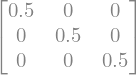

In [3]:
MM = np.power(M, -1/2) # Inverso da raíz quadrada

MM[MM == np.inf] = 0 # Transforma os elementos infinitos em zero

Matrix(MM)

### $$ \text{Cálculo da matriz } \tilde{[K]} = [M^{-1/2}][K][M^{-1/2}]:$$

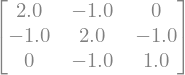

In [4]:
K_til = MM@K@MM # Cálculo da matriz K_til

Matrix(K_til)

### $$ \text{Cálculo da matriz } \tilde{[C]} = [M^{-1/2}][C][M^{-1/2}]:$$

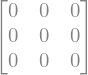

In [5]:
C_til = MM@C@MM # Cálculo da matriz C_til

Matrix(C_til)

### $$\text{Obtendo os autovalores (} \lambda \text{) e autovetores normalizados (} P \text{) de }\tilde{[K]}:$$

In [6]:
lamb, P = np.linalg.eig(K_til) # Obtenção dos autovalores e autovetores normalizados

##### $$\text{Matriz de autovalores }[\lambda]:$$

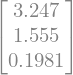

In [7]:
Matrix(lamb.round(4))

##### $$\text{Matriz de autovetores normalizados }[P]:$$

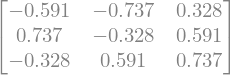

In [8]:
Matrix(P.round(4))

### Cálculo das frequências naturais: $$[\omega_n] = \left[ \sqrt{\lambda} \right]$$

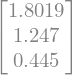

In [9]:
omega_n = np.sqrt(lamb) # Calcula a matriz de freqências naturais, em rad/s

Matrix(omega_n.round(4))

### $$\text{Cálculo da matriz } [S] = [M^{-1/2}][P]$$

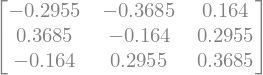

In [10]:
S = MM@P # Cálcula a matriz S

Matrix(S.round(4))

### $$\text{Cálculo da matriz } [\Lambda] = [P^T][\tilde{K}][P]$$

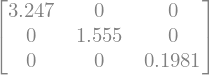

In [11]:
LAMB = P.T@K_til@P # Calcula a matriz LAMBDA, que deve ser igual à matriz diagonal contendo os autovalores

Matrix(LAMB.round(4))

### Transformações de coordenadas das condições iniciais: $$[X_0], [V_0] ~~\rightarrow~~ [R_o], [\dot{R_0}]$$

##### $$\text{Matriz de posição }[X_0] \rightarrow [R_0]:$$

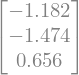

In [12]:
R0 = np.linalg.inv(S)@X0 # Conversão de coordenadas para posição

Matrix(R0.round(4))

##### $$\text{Matriz de velocidade }[V_0] \rightarrow [\dot{R_0}]:$$

In [13]:
RD0 = np.linalg.inv(S)@V0 # Conversão de coordenadas para velocidade

Matrix(RD0.round(4))

### Obter soluções modais desacopladas do tipo: $$r_i(t) = A_isen(\omega_it + \phi_i)$$

### $$\text{Cálculo de } A_i = \frac{\sqrt{\omega_i^2r_{0_i}^2+\dot{r_0}_i^2}}{\omega_i}:$$

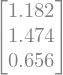

In [14]:
A = (np.sqrt((np.power(omega_n, 2)*np.power(R0, 2))+np.power(RD0, 2))/omega_n) #Cálculo da matriz de amplitudes

Matrix(A.round(4))

### $$\text{Cálculo de } \phi_i = tan^{-1}\left( \frac{\omega_ir_{o_i}}{\dot{r_0}_i} \right):$$

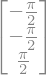

In [15]:
ph = np.arctan((omega_n*R0)/RD0) # Cálculo da matriz de fases, em radianos

PHI = []

for i in ph: #Ajuste para evitar erros de aproximação do ponto flutuante
    PHI.append(nsimplify(round((i/np.pi), 4)*pi))

Matrix(PHI)

### Montando as expressões:

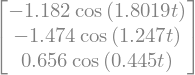

In [16]:
# Definição da forma geral da solução:
a = Symbol('A')
omg = Symbol('\omega')
phi = Symbol('\phi')
t = Symbol('t')
rt = a*sin(omg*t + phi)

# Substituição das respectivas constantes em suas iterações:
RT = []
for i in range(len(omega_n)):
    ri = rt.subs([(a, round(A[i], 4)), (omg, round(omega_n[i], 4)), (phi, PHI[i])])
    RT.append(trigsimp(ri)) # Simplificação trigonométrica

Matrix(RT)

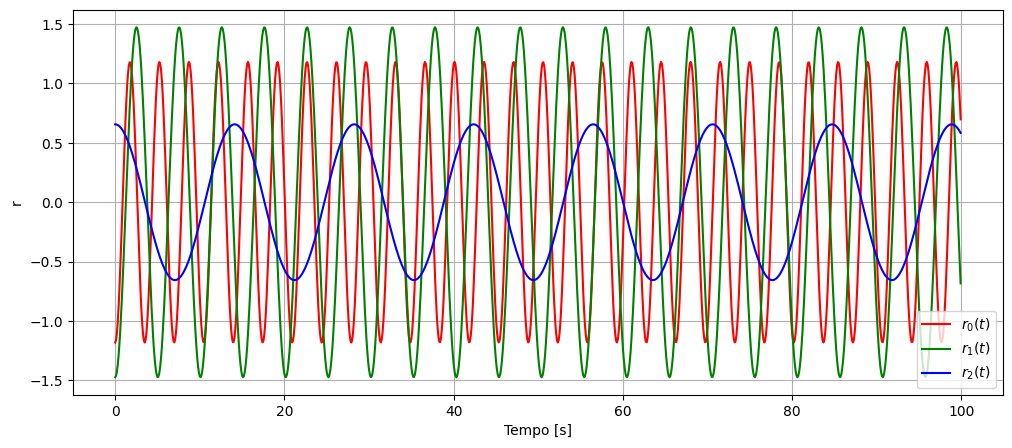

In [22]:
time = np.arange(0, 100, .1) # Criando vetor de tempo

# Criando matriz de posição em função do tempo:
R = []
for i in range(len(RT)):
    R.append([])
    for j in time:
        R[i].append(RT[i].subs(t, j))

# Plotando os gráficos:
plt.figure(1)
plt.rcParams['figure.figsize'] = (12, 5)
for i in range(len(R)):
    plt.plot(time, R[i], color[i], label=f'$r_{i}(t)$')
plt.ylabel('r')
plt.legend()
plt.xlabel('Tempo [s]')
plt.title('')
plt.grid()
plt.show()

### Retornando ao domínio físico:

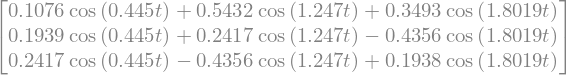

In [18]:
XT = arredNUM(Matrix(S@RT))

Matrix(XT)

### Resposta temporal:

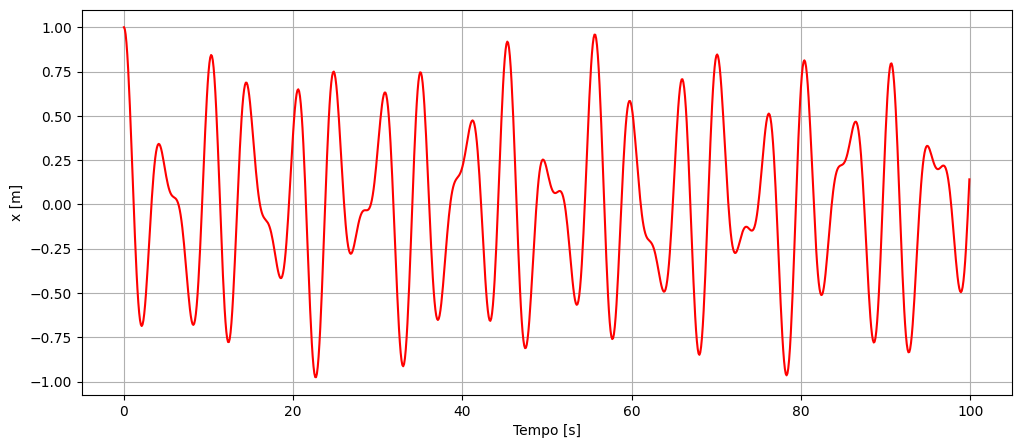

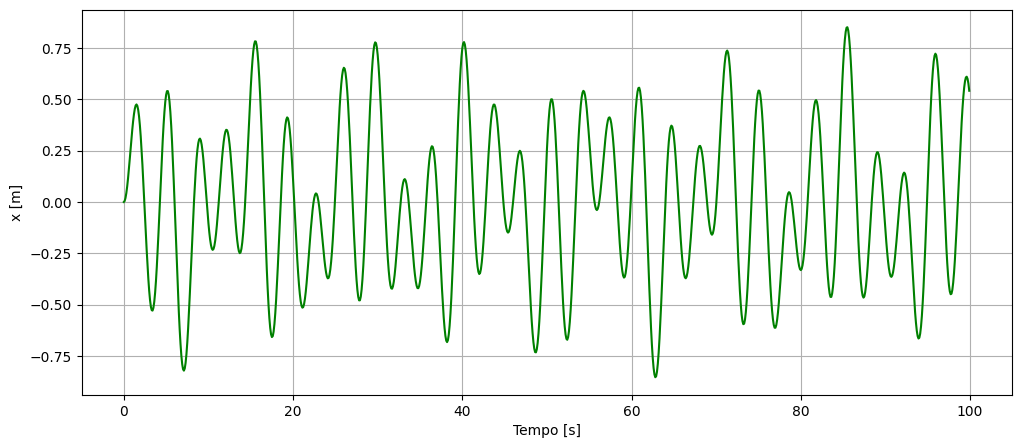

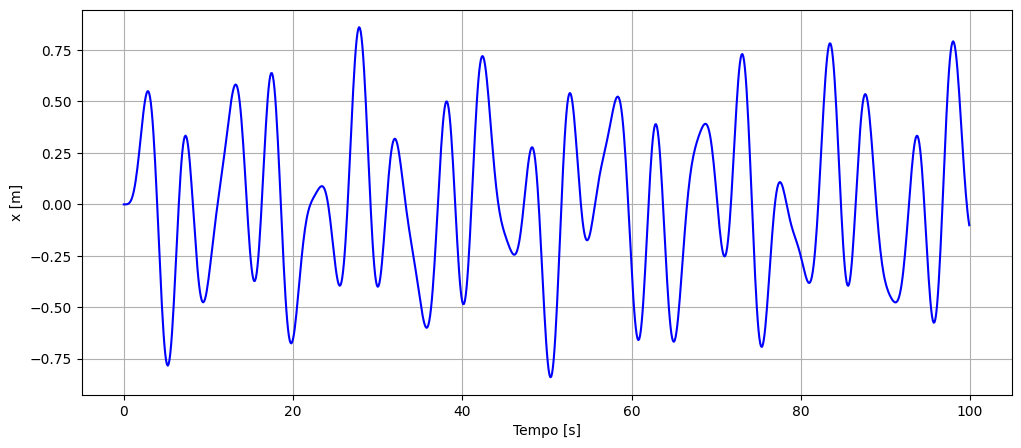

In [19]:
# Criando matriz de posição em função do tempo:
X = []
for i in range(len(XT)):
    X.append([])
    for j in time:
        X[i].append(XT[i].subs(t, j))

# Plotando os gráficos:
for i in range(len(X)):
    plt.figure(i+2)
    plt.rcParams['figure.figsize'] = (12, 5)
    plt.plot(time, X[i], color[i], label='$x(t)$')
    plt.ylabel('x [m]')
    #plt.legend()
    plt.xlabel('Tempo [s]')
    plt.title('')
    plt.grid()
    plt.show()


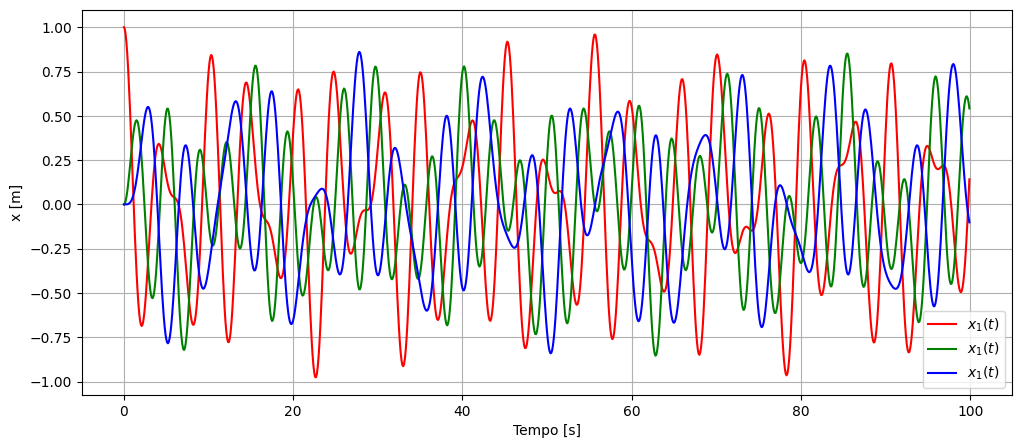

In [20]:
plt.figure(5)
plt.rcParams['figure.figsize'] = (12, 5)
for i in range(len(X)):
    plt.plot(time, X[i], color[i], label='$x_1(t)$')
plt.ylabel('x [m]')
plt.legend()
plt.xlabel('Tempo [s]')
plt.title('')
plt.grid()
plt.show()

### Frequências naturais em Hertz:

In [21]:
for i in range(len(omega_n)):
    print(f'f{i+1} = {round((omega_n[i]/(2*np.pi)), 4)} Hz')

f1 = 0.2868 Hz
f2 = 0.1985 Hz
f3 = 0.0708 Hz
